
### **Contexto**

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### **Nosso objetivo**

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### **O que temos disponível, inspirações e créditos**

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### **Expectativas Iniciais**

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.


## **Importar bibliotecas**

In [ ]:
!pip install -q streamlit

In [ ]:
# importar as bibliotecas necessárias 
import streamlit as st
import pandas as pd
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importar bases de dados
- Para isso, vamos criar um dicionário com os 3 primeiros caracteres com os nomes dos meses e o número correspondente daquele mês.

- Para cada arquivo da base de dados a gente vai importar o arquivo e criar uma coluna na base de dados com o mês e o ano de cada informação

In [ ]:
# criar um dicionário de meses com as 3 primeiras letras
meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

# definir caminho para o pathlib buscar
caminho_bases = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/airbnb_rio/dataset')

# criar DataFrame vazio
base_airbnb = pd.DataFrame()

# para cada arquivo dentro da pasta dataset, criar um DataFrame com esse arquivo e adicionar ao DataFrame base_airbnb
for arquivo in caminho_bases.iterdir():
  # pegar as 3 primeiras letras do mes
  nome_mes = arquivo.name[:3]
  # pegar número do mes
  mes = meses[nome_mes]
  # pegar o ano do mes
  ano = arquivo.name[-8:]
  ano = int(ano.replace('.csv', ''))
  # importar o arquivo e criar o DF
  df = pd.read_csv(caminho_bases / arquivo.name)
  # criar coluna 'ano' e 'mes' no DF
  df['ano'] = ano
  df['mes'] = mes
# acrescentar DF no base_airbnb 
  base_airbnb = base_airbnb.append(df)

display(base_airbnb)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (87) have mixed types.Specify dtype option on import or set low_memory=False.

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (62,87) have mixed types.Specify dtype option on import or set low_memory=False.



,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,ano,mes
0,17878,https://www.airbnb.com/rooms/17878,20200420135919,2020-04-22,Very Nice 2Br - Copacabana - WiFi,Discounts for long term stays. Pls contact me ...,- large balcony which looks out on pedestrian ...,Discounts for long term stays. Pls contact me ...,none,This is the best spot in Rio. Everything happe...,NaN,Excellent location. Close to all major public ...,The entire apartment is yours. It's like your ...,I will be available throughout your stay shoul...,Please leave the apartment in a clean fashion ...,NaN,NaN,https://a0.muscache.com/im/pictures/65320518/3...,NaN,68997,https://www.airbnb.com/users/show/68997,Matthias,2010-01-08,"Rio de Janeiro, State of Rio de Janeiro, Brazil",I am a journalist/writer. Lived for 15 years...,within an hour,100%,99%,t,https://a0.muscache.com/im/pictures/user/67b13...,https://a0.muscache.com/im/pictures/user/67b13...,Copacabana,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Rio de Janeiro, Rio de Janeiro, Brazil",Copacabana,Copacabana,...,30,5.0,5.0,1125.0,1125.0,5.0,1125.0,2 months ago,t,0,0,0,0,2020-04-22,251,25.0,2010-07-15,2020-04-06,93.0,9.0,10.0,10.0,10.0,10.0,9.0,f,NaN,NaN,t,f,strict_14_with_grace_period,f,f,1,1.0,0.0,0.0,2.11,2020,4
1,21280,https://www.airbnb.com/rooms/21280,20200420135919,2020-04-21,Renovated Modern Apt. Near Beach,Immaculately renovated top-floor apartment ove...,Immaculately renovated top-floor apartment in ...,Immaculately renovated top-floor apartment ove...,none,This is the best neighborhood in Zona Sul. Fo...,NaN,The new metro station is just a few steps away...,"This is an older ""Art Deco"" style building, so...",Someone will be there at check in and check ou...,This is a booking agreement for rental of a tw...,NaN,NaN,https://a0.muscache.com/im/pictures/60851312/b...,NaN,81163,https://www.airbnb.com/users/show/81163,Jules,2010-02-14,"Chicago, Illinois, United States",Hi I am Jules and I have a beautiful apartment...,within an hour,100%,90%,f,https://a0.muscache.com/im/users/81163/profile...,https://a0.muscache.com/im/users/81163/profile...,Ipanema,0.0,0.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Rio de Janeiro, RJ, Brazil",Ipanema,Ipanema,...,30,5.0,5.0,30.0,30.0,5.0,30.0,2 months ago,t,9,39,69,69,2020-04-21,94,6.0,2014-02-14,2020-03-22,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,1.0,0.0,0.0,1.25,2020,4
2,25026,https://www.airbnb.com/rooms/25026,20200420135919,2020-04-21,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovati

## **Iniciando os tratamentos**
- Por causa do modelo possuir muitas colunas, pode acabar ficando muito lento.
- Além disso, uma análisa rápida permite ver que várias colunas não são necessárias para o modelo de previsão, por isso, vamos excluir algumas colunas da nossa base,
- Tipos de colunas que vamos excluir:
  - IDs, Links e informações irrelevantes para o modelo;
  - Colunas repetidas ou redundantes. Ex: Data x Ano/Mês
  - Colunas preenchidas com texto livre -> Não rodaremos nenhuma análise de palavras;
  - Colunas vazias;
- Para isso, vamos criar um arquivo em excel com os 1.000 primeiros registros e fazer uma análise qualitativa.

In [ ]:
# printar lista com todas as colunas
print(list(base_airbnb.columns))
# criar um arquivo .csv com as 1000 primeiras linhas das colunas 
base_airbnb.head(1000).to_csv('primeiros_registros_csv', sep=';')

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

### **Depois da análise qualitativa, mativemos as seguintes colunas, seguindo os critérios definidos anteriormente:**


In [ ]:
# selecionar colunas tratadas no excel
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']
base_airbnb = base_airbnb.loc[:, colunas]
display(base_airbnb)

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,within an hour,100%,t,2.0,-22.965920,-43.178960,Condominium,Entire home/apt,5,1.0,2.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$218.00,$0.00,$300.00,2,$50.00,5,30,251,93.0,9.0,10.0,10.0,10.0,10.0,9.0,t,f,strict_14_with_grace_period,2020,4
1,within an hour,100%,f,0.0,-22.984670,-43.196110,Apartment,Entire home/apt,6,2.0,2.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$422.00,"$2,635.00",$263.00,6,$0.00,5,30,94,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,strict_14_with_grace_period,2020,4
2,within a day,60%,f,3.0,-22.977120,-43.190450,Apartment,Entire home/apt,2,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$158.00,"$1,000.00",$250.00,2,$45.00,7,60,238,94.0,9.0,9.0,9.0,10.0,10.0,9.0,f,f,strict_14_with_grace_period,2020,4
3,within an hour,100%,t,1.0,-22.983020,-43.214270,Apartment,Entire home/apt,3,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$342.00,$0.00,$105.00,2,$53.00,2,1125,282,96.0,10.0,10.0,10.0,10.0,10.0,10.0,t,f,strict_14_with_grace_period,2020,4
4,within an hour,100%,f,1.0,-22.988160,-43.193590,Apartment,Entire home/apt,2,1.5,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$479.00,"$1,329.00",$218.00,2,$0.00,2,89,181,94.0,10.0,9.0,10.0,10.0,10.0,9.0,f,f,strict_14_with_grace_period,2020,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35597,within a day,50%,f,1.0,-22.961213,-43.223335,Apartment,Private room,2,1.0,1.0,2.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",$159.00,"$5,000.00",$150.00,2,$150.00,2,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2018,11
35598,NaN,NaN,f,1.0,-23.000335,-43.418198,House,Entire home/apt,11,4.0,4.0,7.0,Real Bed,"{TV,Wifi,""Air conditioning"",Pool,Kitchen,""Free...",$501.00,NaN,NaN,1,$0.00,1,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2018,11
35599,NaN,NaN,f,2.0,-22.917032,-43.212499,Apartment,Private room,2,1.0,1.0,2.0,Real Bed,"{Wifi,""Air conditioning"",Kitchen,Washer,Essent...",$80.00,NaN,NaN,1,$0.00,1,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2018,11
35600,within an hour,100%,f,1.0,-22.968013,-43.183911,Apartment,Entire home/apt,5,1.0,2.0,5.0,Real Bed,"{TV,Wifi,Kitchen,Elevator,Heating,Washer,Essen...",$334.00,NaN,NaN,1,$0.00,5,22,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,f,flexible,2018,11


## **Tratar Valores Faltando**

- Visualizando os dados, percebemos que existe uma grande disparidade em dados faltantes. As colunas com mais de 300.000 valores NaN (vazios) foram excluídas da análise;
- Para as outras colunas, como temos muitos dados (maias de 900.000 linhas) vamos excluir as linhas que contpem dados NaN.


In [ ]:
# printar quantidade de colunas com dados NaN para tratar
print(base_airbnb.isnull().sum())

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

- Excluindo linhas vazias

In [ ]:
# retirar colunas com mais de 300 mil dados NaN
for coluna in base_airbnb:
  if base_airbnb[coluna].isnull().sum() >= 300000:
    base_airbnb = base_airbnb.drop(coluna, axis=1)

print(base_airbnb.isnull().sum())

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


In [ ]:
# retirar linhas que contém dados NaN
base_airbnb = base_airbnb.dropna()
# printar quantidade de colunas com dados NaN
print(base_airbnb.isnull().sum())
# contar quantas linhas e colunas têm
print(base_airbnb.shape)

2021-04-02 22:58:01.226 INFO    numexpr.utils: NumExpr defaulting to 2 threads.


host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64
(897709, 23)


## **Verificar os tipos de dados de cada coluna**

In [ ]:
# printar tipos de dados
print(base_airbnb.dtypes)
print('-'*80)
# printar primeira linha de cada coluna
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
--------------------------------------------------------------------------------
host_is_superhost                                                           t

- Como preço e extra people estão sendo reconhecidos como objeto (e deveriam ser um float) temos que mudar o tipo de variável da coluna

In [ ]:
# transformar dados da coluna price e extra people em float
#price
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)
# extra_people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)
# verificando os tipos
print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


### **Análise Exploratória e Tratar Outliers**

- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

MAS CUIDADO: não saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança ai. Claro que você sempre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo também e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo

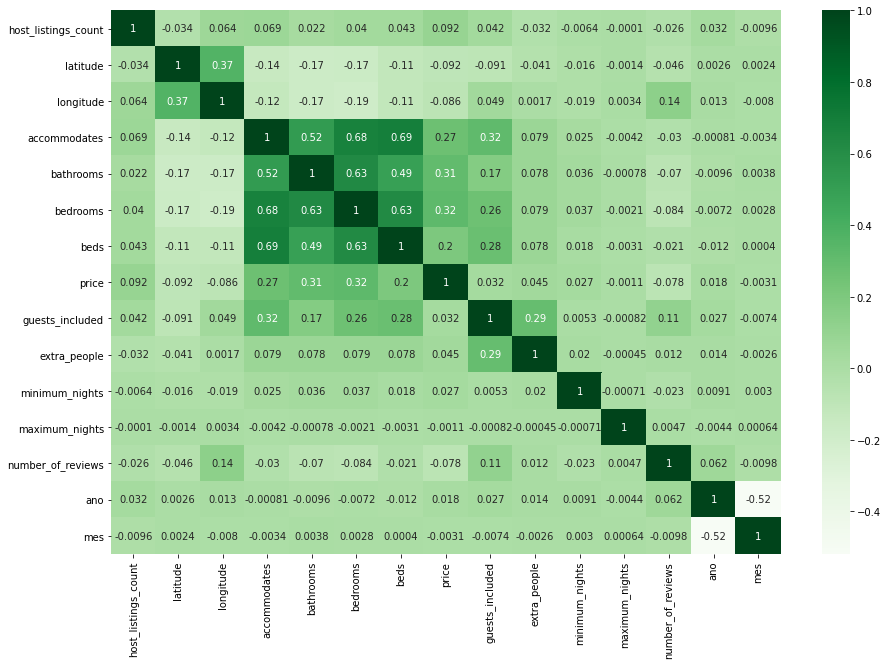

In [ ]:
# tamanho da figura
plt.figure(figsize=(15, 10))
# plotar mapa de calor para analisar correlações
sns.heatmap(base_airbnb.corr(), annot=True, cmap='Greens')

### **Definição de Funções para Análise de Outliers**
- Definir funções para ajudar na análise de outliers das colunas

In [ ]:
# função para definir outliers
def limites(coluna):
  # primeiro quartil
  q1 = coluna.quantile(0.25)
  # terceiro quartil
  q3 = coluna.quantile(0.75)
  amplitude = q3 - q1
  # retonar limite inferior e limite superior
  return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

# função para remover outliers
def excluir_outliers(df, nome_coluna):
  qtde_linhas = df.shape[0]
  lim_inf, lim_sup = limites(df[nome_coluna])
  df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
  return df, qtde_linhas - df.shape[0]

In [ ]:
# definir as funções dos gráficos

# função do gráfico do diagrama
def diagrama_caixa(coluna):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(15, 5)
  sns.boxplot(x=coluna, ax=ax1)
  ax2.set_xlim(limites(coluna))
  sns.boxplot(x=coluna, ax=ax2)

# função do gráfico do histograma
def histograma(coluna):
  plt.figure(figsize=(15, 5))
  sns.distplot(coluna, hist=True)

# função do gráfico de barra
def grafico_barra(coluna):
  plt.figure(figsize=(15,5))
  ax = sns.barplot(x= coluna.value_counts().index, y=coluna.value_counts())
  ax.set_xlim(limites(coluna))

- **price**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



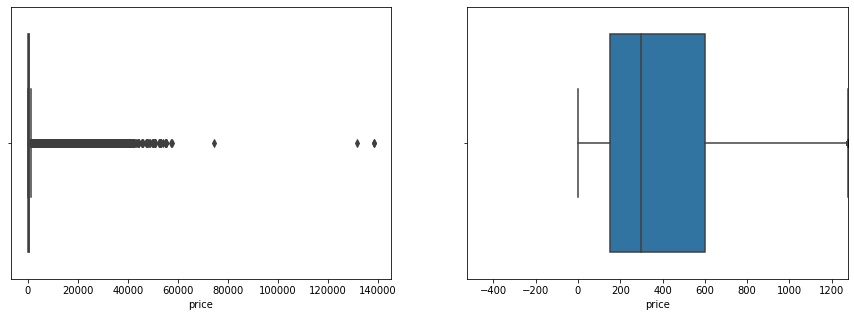

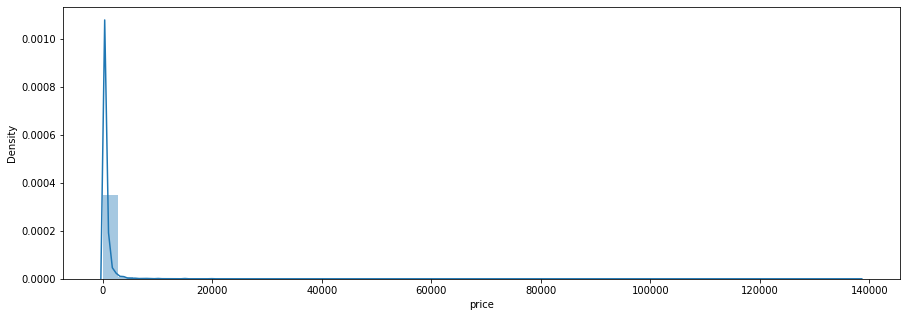

In [ ]:
# plotar gráficos price
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

- Como estamos construindo um modelo para imóveis comuns, acredito que os valores acima do limite superior serão apenas de altíssimo luxo, o que não é o nosso objetivo principal. Por isso, podes excluir esses outliers

In [ ]:
# printar quantidade de linhas removidas e definir novo DF com outliers excluidos
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print('{} linhas removidas'.format(linhas_removidas))

87282 linhas removidas


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



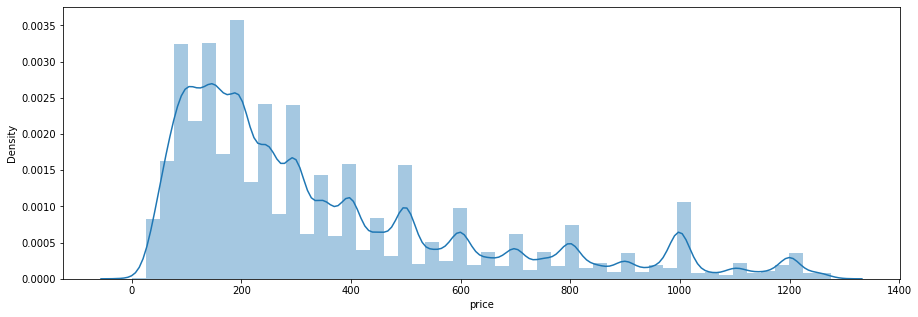

In [ ]:
# plotar histograma price
histograma(base_airbnb['price'])

- **extra_people**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



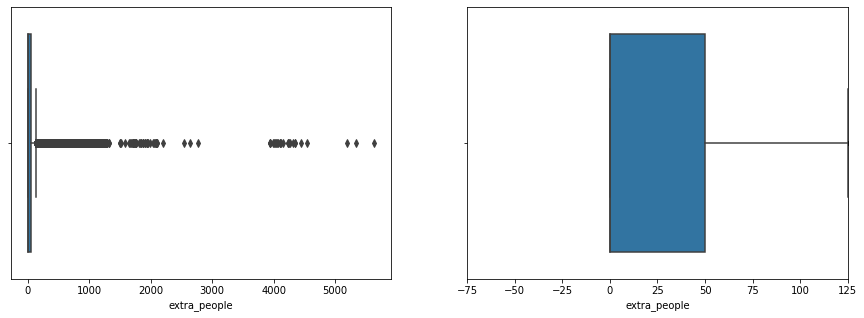

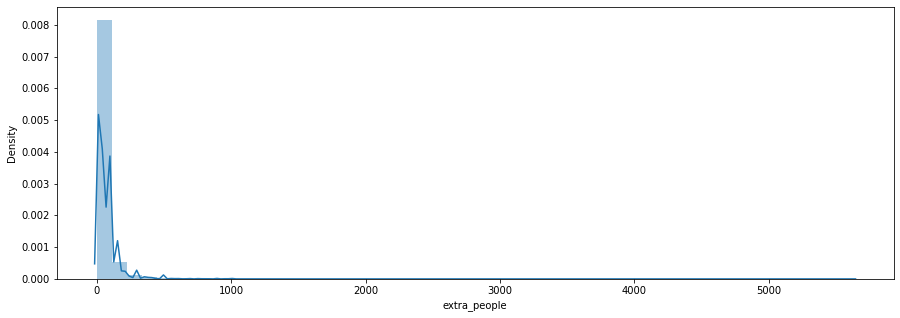

In [ ]:
# plotar gráficos extra_people
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [ ]:
# printar quantidade de linhas removidas e definir novo DF com outliers excluidos
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print('{} linhas removidas'.format(linhas_removidas))

59194 linhas removidas


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



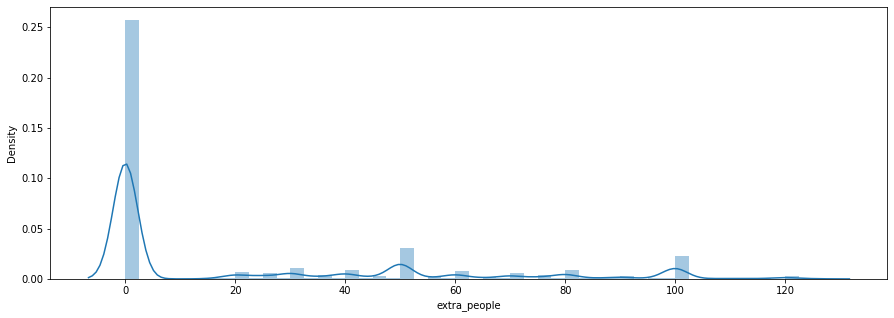

In [ ]:
# plotar histograma extra_people
histograma(base_airbnb['extra_people'])

-  **host_listings_count**



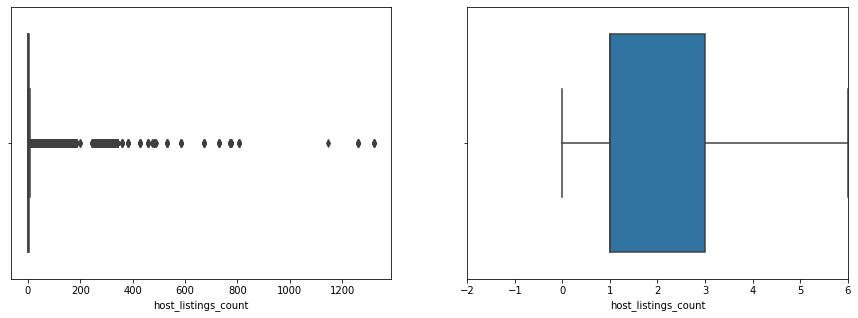

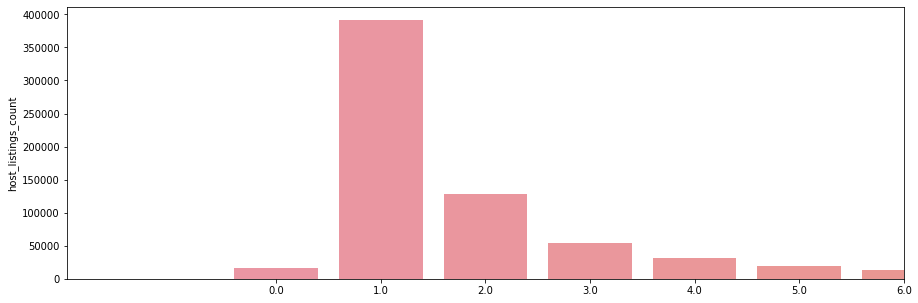

In [ ]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

- Podemos excluir os outliers, porque para o objetivo do nosso projeto hosts com mais de 6 imóveis no airbnb não são o público alvo do objetivo do projeto (provavelmente sejam imobiliárias ou profissionais que gerenciam imóveis no airbnb)

In [ ]:
 # printar quantidade de linhas removidas e definir novo DF com outliers excluidos
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print('{} linhas removidas'.format(linhas_removidas))

97723 linhas removidas


 - **accommodates**    

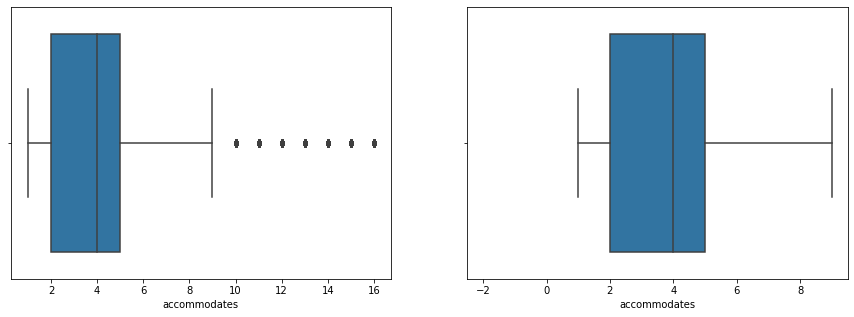

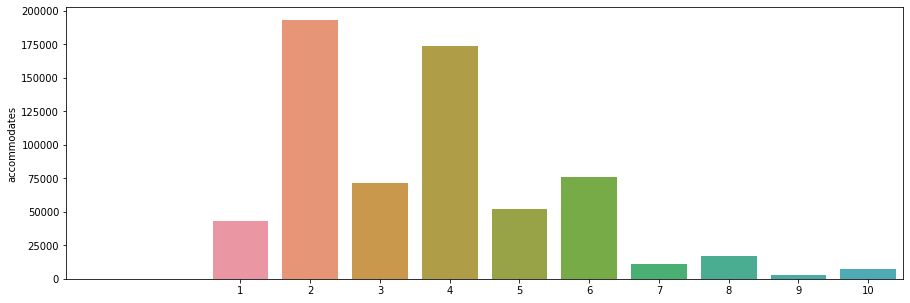

In [ ]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

In [ ]:
# printar quantidade de linhas removidas e definir novo DF com outliers excluidos
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print('{} linhas removidas'.format(linhas_removidas))

13146 linhas removidas


- **bathrooms**
  - Estava acontecendo um bug na hora em que o gráfico era plotado, por isso plotamos manualmente (por ter poucos valores não definimos o limite)

<Figure size 1080x360 with 0 Axes>

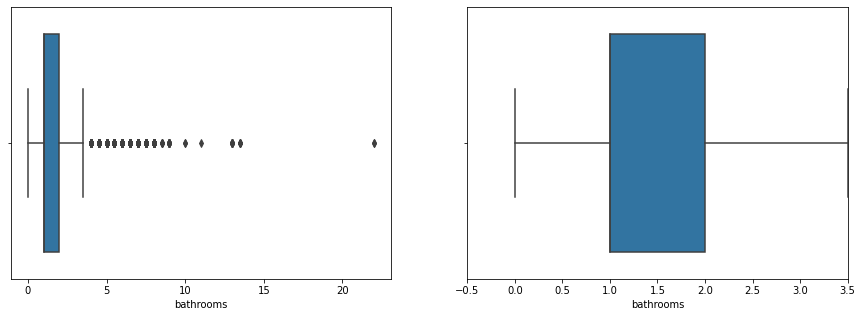

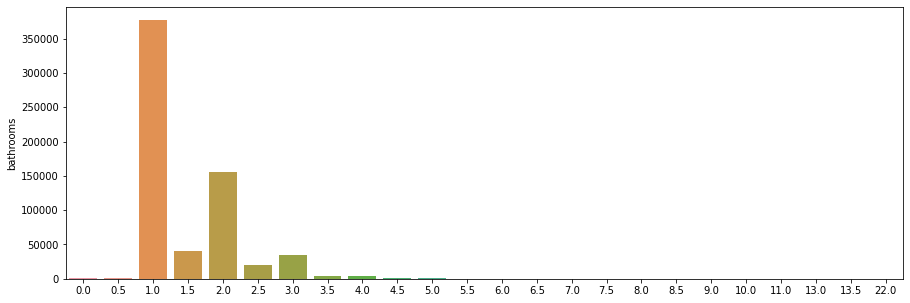

<Figure size 1080x360 with 0 Axes>

In [ ]:
# plotar os gráficos manualmente
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())
plt.figure(figsize=(15, 5))

In [ ]:
# printar quantidade de linhas removidas e definir novo DF com outliers excluidos
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print('{} linhas removidas'.format(linhas_removidas))

6894 linhas removidas


- **bedrooms**



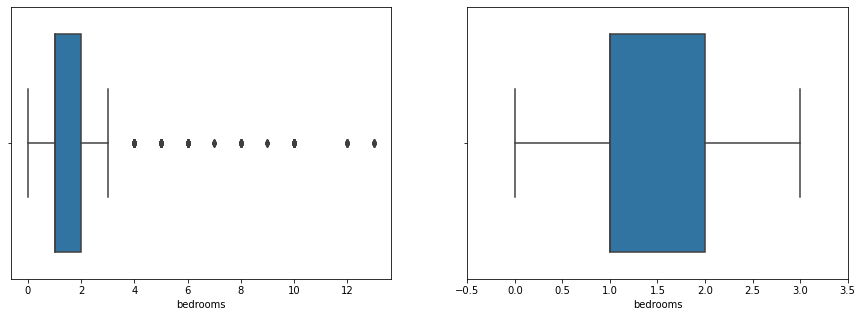

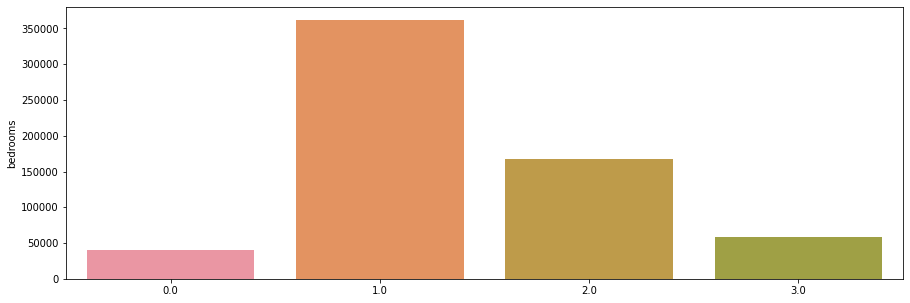

In [ ]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

In [ ]:
# printar quantidade de linhas removidas e definir novo DF com outliers excluidos
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print('{} linhas removidas'.format(linhas_removidas))

5482 linhas removidas


- **beds**

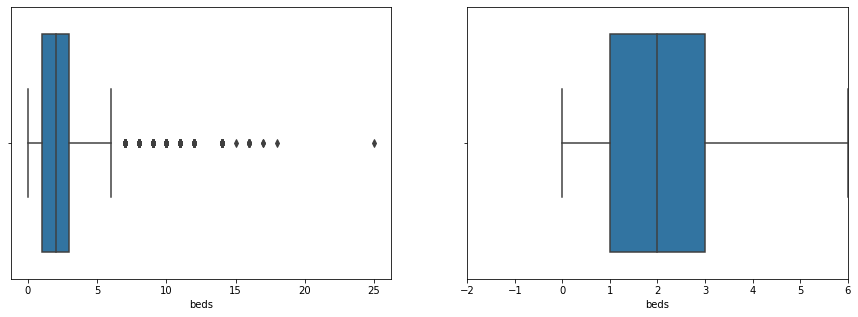

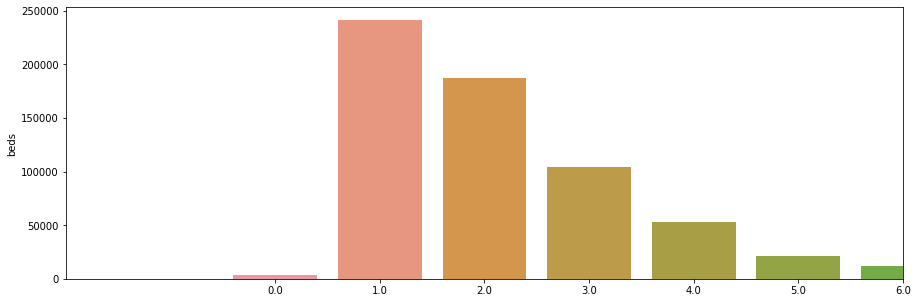

In [ ]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

In [ ]:
# printar quantidade de linhas removidas e definir novo DF com outliers excluidos
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print('{} linhas removidas'.format(linhas_removidas))

5622 linhas removidas


- **guests_included**
  - Vamos remover essa feature da análise. Parece que os usuários do airbnb usam muito o valor padrão do airbnb como 1 guest included. Isso pode levar o nosso modelo a considerar uma feature que na verdade não é essencial para a definição do preço, por isso, me parece melhor excluir a coluna da análise.

(1.0, 1.0)


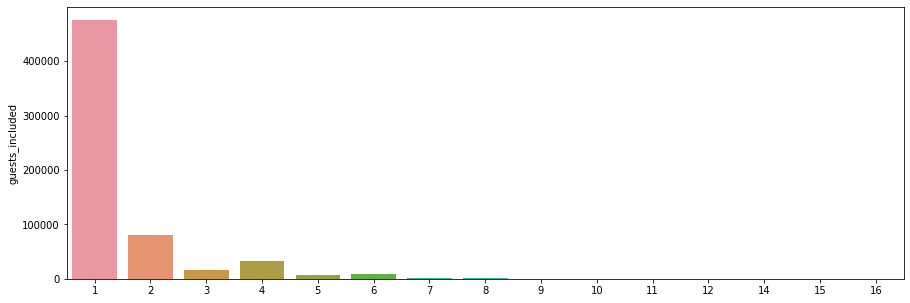

In [ ]:
# diagrama_caixa(base_airbnb['guests_included'])
# grafico_barra(base_airbnb['guests_included'])

# printar limites entender o gráfico
print(limites(base_airbnb['guests_included']))

# plotar gráfico de barra manualmente por causa dos limites serem ambos "1.0"
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

In [ ]:
# excluir coluna guests_included seguindo a lógica apresentada posteriormente
base_airbnb = base_airbnb.drop('guests_included', axis=1)
# printar a quantidade de linhas e colunas atuais
base_airbnb.shape

(622366, 22)

- **minimum_nights**

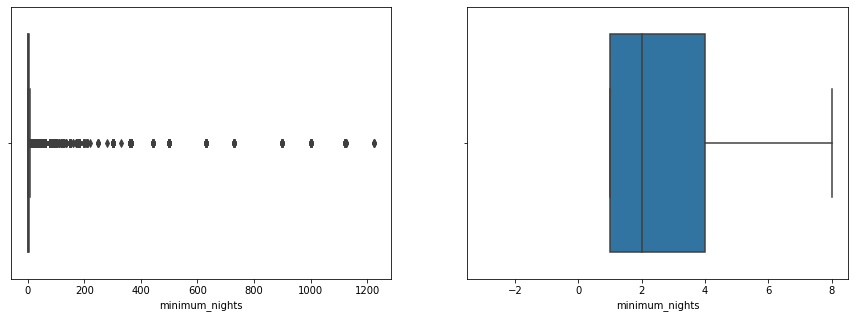

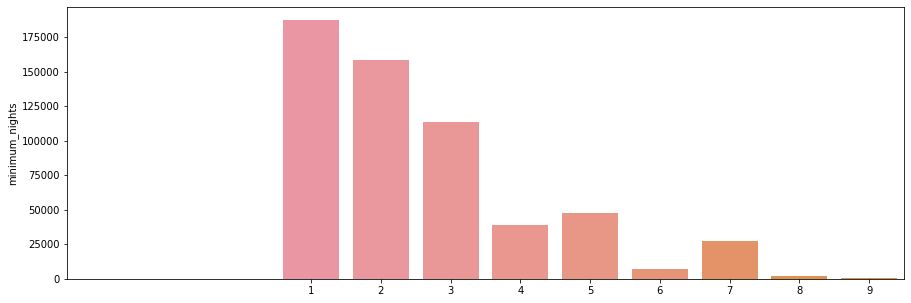

In [ ]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

In [ ]:
# printar quantidade de linhas removidas e definir novo DF com outliers excluidos
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print('{} linhas removidas'.format(linhas_removidas))

40383 linhas removidas


- **maximum_nights**
  - Para a nossa análise não faz sentido pegar o máximo de noites, tendo em vista que o padrão de preenchimento do airbnb é 0 e que também possui muitos números grandes

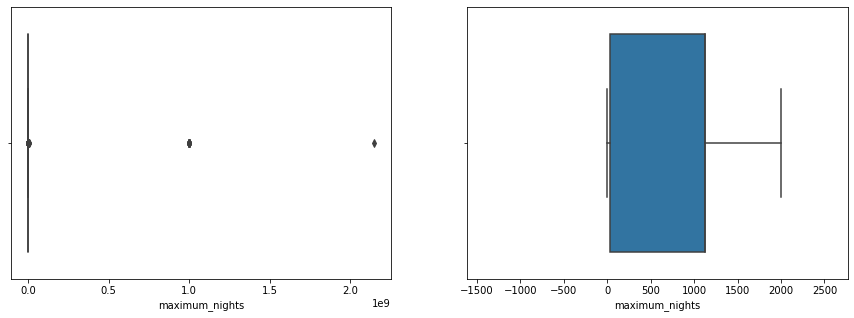

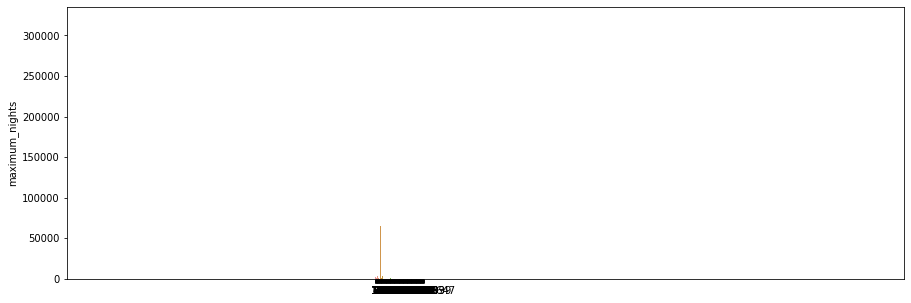

In [ ]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

In [ ]:
# excluir coluna guests_included seguindo a lógica apresentada posteriormente
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
# printar a quantidade de linhas e colunas atuais
base_airbnb.shape

(581983, 21)

- **number_of_reviews**
  - Iremos retirar essa coluna pelo fato de estarmos levando em conta uma pessoa que irá anunciar pela primeira vez, assim, ela não teria review nenhuma

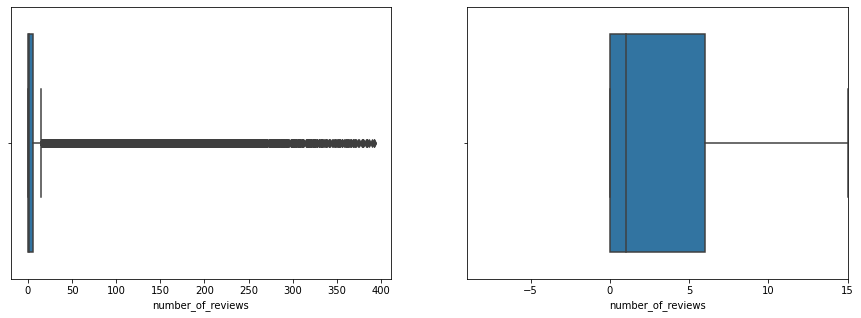

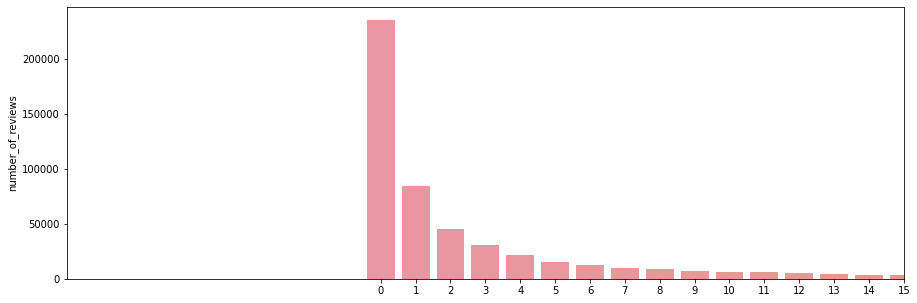

In [ ]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

In [ ]:
# excluir coluna guests_included seguindo a lógica apresentada posteriormente
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
# printar a quantidade de linhas e colunas atuais
base_airbnb.shape

(581983, 20)

**Tratamento de Colunas de Valores de Texto**
  - Vamos tratar as categorias seguindo a lógica de que caso houver muitas categorias com números relativamente baixos, iremos agrupar em um só grupo para não termos dados pulverizados. Caso o contrário, não iremos mexer na estrutura.

- **property_type**

Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



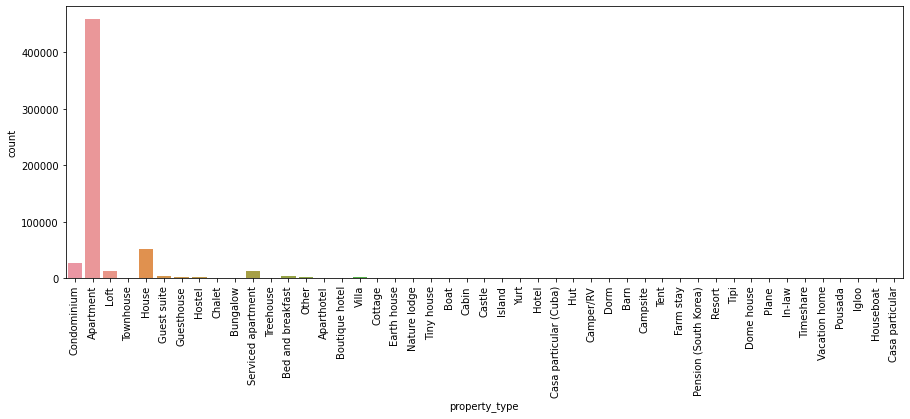

In [ ]:
# printar quantidade de categorias
print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

Por mostrar muitas categorias com poucos dados a análise acaba ficando pulverizada, por isso, vamos criar uma lista auxiliar ```imoveis_agrupados``` para juntar todas categorias com valores menores que 2000 e agrupar no grupo ```others``` 


Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Others                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: property_type, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



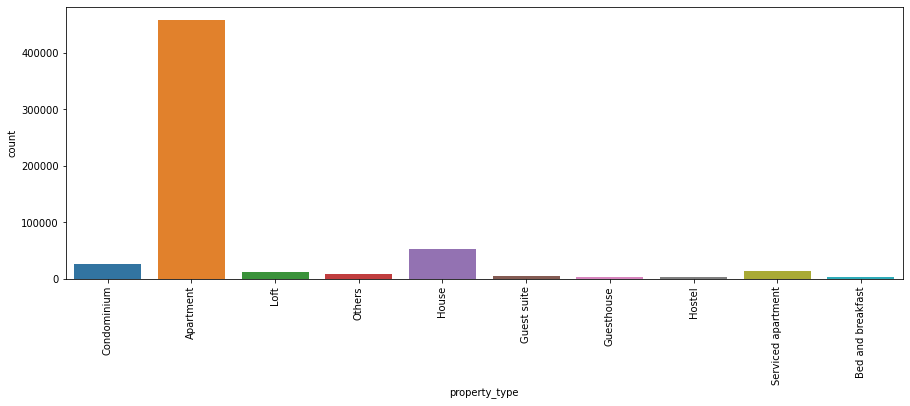

In [ ]:
# criar váriavel para categorias de imóveis e a lista auxiliar vazia
tipos_imoveis = base_airbnb['property_type'].value_counts()
imoveis_agrupados = []

# adicionar imóveis com menos de 2000 dados à lista auxiliar
for tipo in tipos_imoveis.index:
  if tipos_imoveis[tipo] < 2000:
    imoveis_agrupados.append(tipo)
# print(imoveis_agrupados)

# agrupar lista auxiliar à um só grupo
for tipo in imoveis_agrupados:
  base_airbnb.loc[base_airbnb['property_type']==tipo, 'property_type'] = 'Others'

# printar quantidade de categorias
print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

- **room_type**

Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: room_type, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



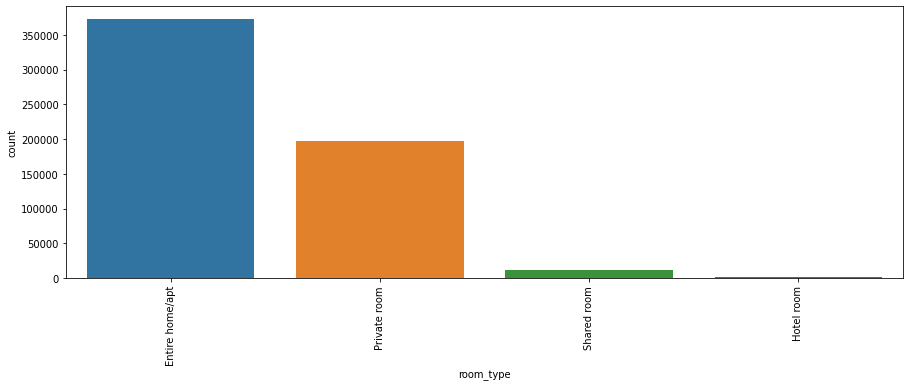

In [ ]:
# printar quantidade de categorias
print(base_airbnb['room_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('room_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

- **bed_type**

Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: bed_type, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



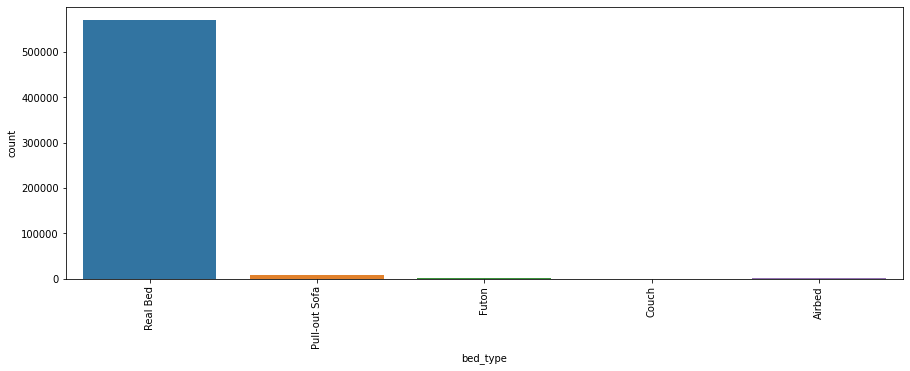

In [ ]:
# printar quantidade de categorias
print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

Real Bed      570643
Others Bed     11340
Name: bed_type, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



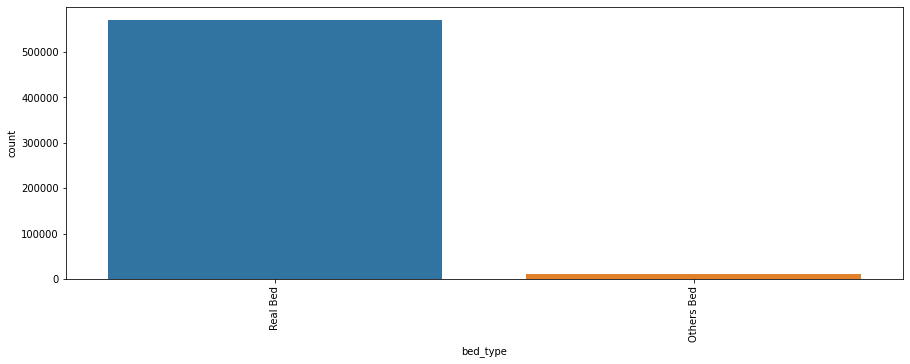

In [ ]:
# criar váriavel para categorias de beds e a lista auxiliar vazia
tipos_bed = base_airbnb['bed_type'].value_counts()
bed_agrupados = []

# adicionar imóveis com menos de 2000 dados à lista auxiliar
for tipo in tipos_bed.index:
  if tipos_bed[tipo] < 10000:
    bed_agrupados.append(tipo)

# agrupar lista auxiliar à um só grupo
for tipo in bed_agrupados:
  base_airbnb.loc[base_airbnb['bed_type']==tipo, 'bed_type'] = 'Others Bed'

# printar quantidade de categorias
print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

- **cancellation_policy**

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: cancellation_policy, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



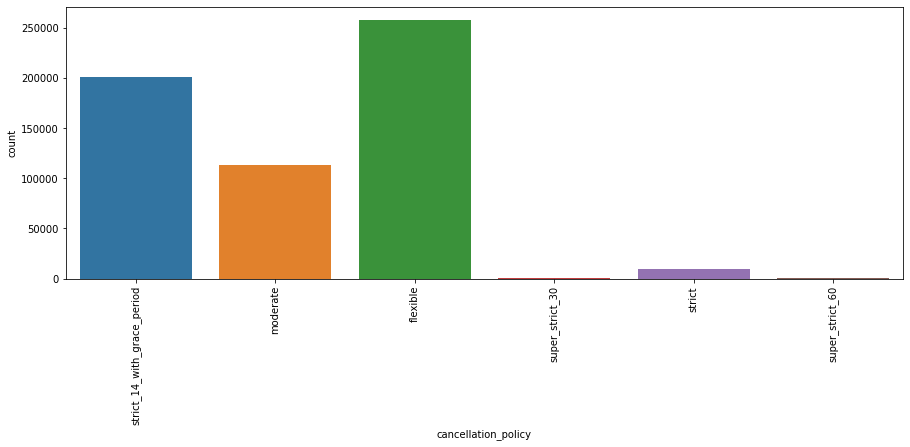

In [ ]:
# printar quantidade de categorias
print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)



Por mostrar 3 categorias com um valor muito menor do que as outras, por isso, vamos criar uma lista auxiliar ```cancelamentos_agrupados``` para juntar as categorias com valores menores que 10000 e agrupar no grupo ```stricts```

['strict', 'super_strict_60', 'super_strict_30']
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
stricts                          9863
Name: cancellation_policy, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



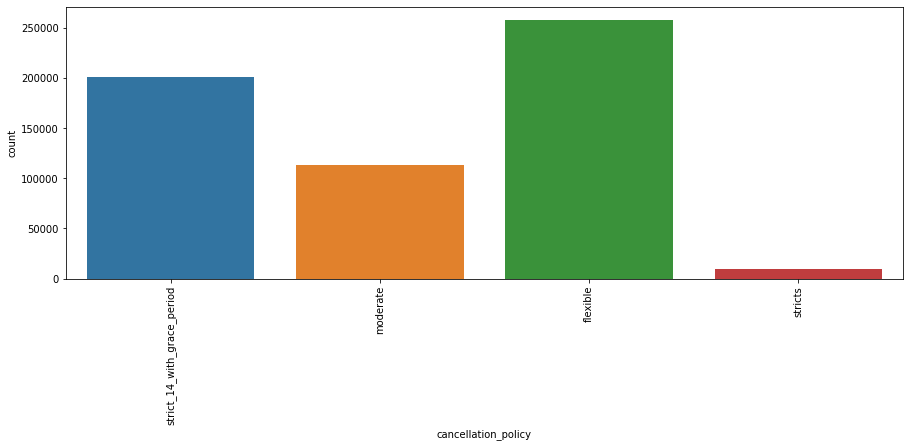

In [ ]:
# criar váriavel para categorias de imóveis e a lista auxiliar vazia
tipos_cancelamento = base_airbnb['cancellation_policy'].value_counts()
cancelamentos_agrupados = []

# adicionar cancelamentos com menos de 10000 dados à lista auxiliar
for tipo in tipos_cancelamento.index:
  if tipos_cancelamento[tipo] < 10000:
    cancelamentos_agrupados.append(tipo)
print(cancelamentos_agrupados)

# agrupar tabela auxiliar à um só grupo
for tipo in cancelamentos_agrupados:
  base_airbnb.loc[base_airbnb['cancellation_policy']==tipo, 'cancellation_policy'] = 'stricts'

# printar quantidade de categorias
print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

- **amenities**
  - Como temos uma diversidade muito grande de amenities e, às vezes, as mesmas amenities podem ser escritas de forma diferente, vamos avaliar a quantidade de amenities como o parâmetro para o nosso modelo.

In [ ]:
# visualizar como estão aparecendo os dados de amenities
print(base_airbnb['amenities'].iloc[1].split(','))
print(len(base_airbnb['amenities'].iloc[1].split(',')))

# criar uma nova coluna 'n_amenities' com a contagem de amenities
base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

# excluir a coluna com os dados amenities para deixar apenas a quantidade de amenities
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', 'Doorman', 'Elevator', '"Buzzer/wireless intercom"', 'Heating', 'Washer', 'Dryer', 'Essentials', 'Shampoo', '"24-hour check-in"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"', '"Dishes and silverware"}']
20


(581983, 20)

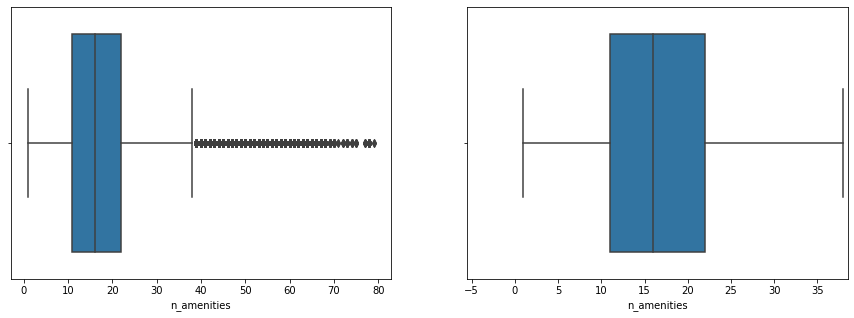

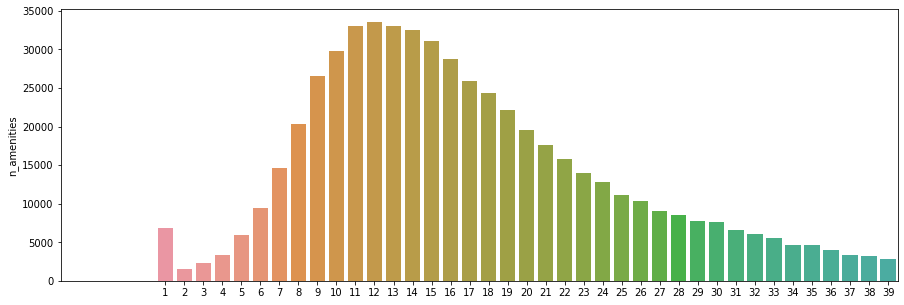

In [ ]:

diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

In [ ]:
# printar quantidade de linhas removidas e definir novo DF com outliers excluidos
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n_amenities')
print('{} linhas removidas'.format(linhas_removidas))

24343 linhas removidas


**Visualização de Mapa das Propriedades**
- Vamos usar o mapa para visualizar as áreas de maior densidade de acordo com o preço, seguindo a lógica:
  - Áreas mais amarelas com o maior preço;
  - Áreas mais roxas com o menor preço;
  - Definir a amostra do mapa de densidade para 50 mil imóveis, para facilitar a visualização da densidade no mapa e também para tornar o processamento mais rápido.

In [ ]:
# mapa de densidade
amostra = base_airbnb.sample(n=50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude', z='price', radius=2.5,
                         center=centro_mapa, zoom=10,
                         mapbox_style='stamen-terrain')
mapa.show()

**Encoding**

- Precisamos ajustar as features apra facilitar o trabalho do modelo futuro (features de categoria, true e false, etc.)
  - Features de Valores ```True``` ou ```False```, vamos substituir ```True``` por ```1```  e ```False``` por ```0``` 
  - Features de Categoria (features em que os valores da coluna são textos) vamos utilizar o método de encoding de variáveis dummies

In [ ]:
# criar lista de colunas True ou False
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
# criar uma cópia encoding para não alterar o DF original
base_airbnb_cod = base_airbnb.copy()
for coluna in colunas_tf:
   base_airbnb_cod.loc[base_airbnb_cod[coluna]=='t', coluna] = 1
   base_airbnb_cod.loc[base_airbnb_cod[coluna]=='f', coluna] = 0
# print(base_airbnb_cod.iloc[0])

In [ ]:
# criar lista de colunas que serão dummies
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
# aplicar o metódo dummie
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias)
display(base_airbnb_cod.head())

,host_is_superhost,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,extra_people,minimum_nights,instant_bookable,is_business_travel_ready,ano,mes,n_amenities,property_type_Apartment,property_type_Bed and breakfast,property_type_Condominium,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_Loft,property_type_Others,property_type_Serviced apartment,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Others Bed,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_stricts
0,1,2.0,-22.96592,-43.17896,5,1.0,2.0,2.0,218.0,50.0,5,1,0,2020,4,33,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
1,0,0.0,-22.98467,-43.19611,6,2.0,2.0,4.0,422.0,0.0,5,0,0,2020,4,20,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
2,0,3.0,-22.97712,-43.19045,2,1.0,1.0,2.0,158.0,45.0,7,0,0,2020,4,16,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
3,1,1.0,-22.98302,-43.21427,3,1.0,1.0,1.0,342.0,53.0,2,1,0,2020,4,26,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
4,0,1.0,-22.98816,-43.19359,2,1.5,1.0,1.0,479.0,0.0,2,0,0,2020,4,34,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0



**Modelo de Previsão**

- Métricas de Avaliação

In [ ]:
# função para avaliar o modelo 
def avaliar_modelo(nome_modelo, y_teste, previsao):
  r2 = r2_score(y_teste, previsao)
# raiz do erro quadrático médio
  RSME = np.sqrt(mean_squared_error(y_teste, previsao))
  return f'Modelo {nome_modelo}:\nR²:{r2:.2%}\nRSME:{RSME:.2f}'


- Escolha dos Modelos a Serem Testados
  1. RandomForest
  2. LinearRegression
  3. ExtraTree

In [ ]:
# armazenar modelos em variáveis para futuros testes
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

# criar dicionário de modelos
modelos = {'RandomForest': modelo_rf,
           'LinearRegression': modelo_lr,
           'ExtraTrees': modelo_et,
           }
# definir variáveis          
y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

- Separar os dados em treino e teste + Treino do Modelo

In [ ]:
# dividir variáveis de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

# treinar e testar cada modelo
for nome_modelo, modelo in modelos.items():
  # treinar
  modelo.fit(X_train, y_train)
  # testar
  previsao = modelo.predict(X_test)
  print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²:97.29%
RSME:43.49
Modelo LinearRegression:
R²:32.61%
RSME:216.83
Modelo ExtraTrees:
R²:97.45%
RSME:42.19


**Análise do Melhor Modelo**

In [ ]:
for nome_modelo, modelo in modelos.items():
  # testar
  previsao = modelo.predict(X_test)
  print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²:97.29%
RSME:43.49
Modelo LinearRegression:
R²:32.61%
RSME:216.83
Modelo ExtraTrees:
R²:97.45%
RSME:42.19


- Modelo Escolhido como Melhor Modelo: ```ExtraTreesRegressor```

  - Esse foi o modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME. Como não tivemos uma grande diferença na velocidade de treino e de previsão desse modelo com o modelo ```RandomForest``` (que teve resultados próximos de R² e RSME), optamos por escolher o Modelo ```ExtraTrees```.
  
  - O modelo de regressão linear não obteve um resultado satisfatório, com valores de R² e RSME menores que os outros 2 modelos.

**Ajustes e Melhorias no Melhor Modelo**

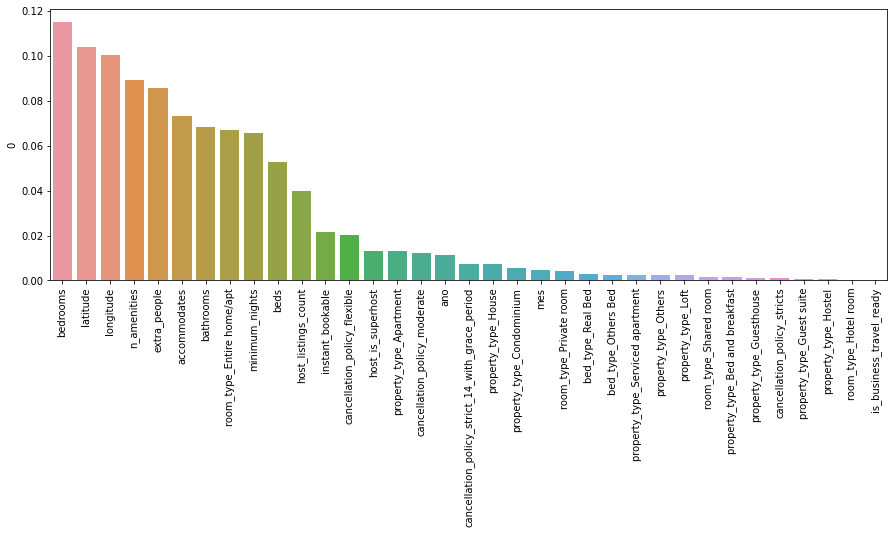

In [ ]:
# mostrar features do modelo ExtraTrees
# print(modelo_et.feature_importances_)
# print(X_train.columns)
# criar DF para visualizar a importância das features
importancia_features = pd.DataFrame(modelo_et.feature_importances_, X_train.columns)
# colocar em ordem decrescente
importancia_features = importancia_features.sort_values(by=0, ascending=False)
# display(importancia_features)
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

**Ajustes Finais no Modelo**
- ```is_business_travel_ready``` não parece ter muito impacto no nosso modelo. Por isso, para chegar em um modelo mais simples, iremos excluir essa feature e testar o modelo sem ela

In [ ]:
base_airbnb_cod = base_airbnb_cod.drop('is_business_travel_ready', axis=1)

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

# dividir variáveis de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

# treinar
modelo_et.fit(X_train, y_train)
# testar
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))


Modelo ExtraTrees:
R²:97.42%
RSME:42.42


- Testamos o modelo sem a feature ```bed_type```, e como houve uma mínima diferença no R² (de 97.45% para 97.44%) e no RSME (de 42.16 para 42.25) optamos por retirar a feature por deixar o modelo mais simples.

In [ ]:
# criar cópia da base 
base_teste = base_airbnb_cod.copy()
for coluna in base_teste:
  if 'bed_type' in coluna:
    base_teste = base_teste.drop(coluna, axis=1)

y = base_teste['price']
X = base_teste.drop('price', axis=1)

# dividir variáveis de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

# treinar
modelo_et.fit(X_train, y_train)
# testar
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Modelo ExtraTrees:
R²:97.43%
RSME:42.38


**Deploy do Projeto**

In [ ]:
X['price'] = y
X.to_csv('/content/drive/MyDrive/dados.csv')

In [ ]:
import joblib
joblib.dump(modelo_et, '/content/drive/MyDrive/modelo.joblib')

['/content/drive/MyDrive/modelo.joblib']